## Overview

- Family Classification is an on_to_many classification problem that intended to determine the family that an unseen subject belongs to by referencing faces, families modeled using facial images of all but the held-out family members, then at test time the held ot family memebers are used to evaluate on.

- To solving this task a random guess will be used as a benchmark model and a CNN will be trained to be used as the main model to compare their results.

In [1]:
import warnings
warnings.filterwarnings('ignore')

- Importing some useful libraries and pakages that will be used along the notebook.

In [2]:
import os
import glob
import base64
import zipfile
import itertools
import numpy as np
import pandas as pd
import seaborn as sn
from PIL import Image
from io import BytesIO
from itertools import chain
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import defaultdict
from keras.preprocessing import image
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Data Exploration & Preprocessing

- Load the val_gallery_face_list file that contains the training samples on a dataframe df.


- It's found that it has 4030 record and 7 columns described as follows:

    - MID contains the member id also represents the name of the folder that contains the member photos.
    - Name of the person in the photo.
    - Gender of the person in the photo.
    - Facepaths column contains a path to a photo of the person.
    - Nfaces represent the number of photos for that person that exists in the database. 
    - FID contains the family id of the person.
    - Tage contains the tag of the image that represents who is the person (the MID part) and from which family is the person.

In [3]:
df = pd.read_excel('train/val_gallery_face_list.xlsx')
print(df.shape)
df.head()

(4030, 7)


,MID,Name,Gender,facepaths,nfaces,FID,tag
0,MID1,bhumibol,m,FIDs/F0007/MID1/P00074_face3.jpg,14,F0007,F0007/MID1
1,MID1,bhumibol,m,FIDs/F0007/MID1/P11274_face3.jpg,14,F0007,F0007/MID1
2,MID1,bhumibol,m,FIDs/F0007/MID1/P00079_face1.jpg,14,F0007,F0007/MID1
3,MID1,bhumibol,m,FIDs/F0007/MID1/P11275_face2.jpg,14,F0007,F0007/MID1
4,MID1,bhumibol,m,FIDs/F0007/MID1/P00078_face3.jpg,14,F0007,F0007/MID1


- df contains 7 columns as shown from the output of the pervious cell.
- Logically it's found that 3 of those column (Name, Gender, nfaces) are found to be useless here so they will be dropped.
- For the facepaths column the paths will be updated to be the correct paths for our machine.

In [4]:
df = df.drop(['Name', 'Gender', 'nfaces'], axis = 1)
df = df.replace(to_replace = r'^FIDs', value = 'train/gallery', regex = True)
df.head()

,MID,facepaths,FID,tag
0,MID1,train/gallery/F0007/MID1/P00074_face3.jpg,F0007,F0007/MID1
1,MID1,train/gallery/F0007/MID1/P11274_face3.jpg,F0007,F0007/MID1
2,MID1,train/gallery/F0007/MID1/P00079_face1.jpg,F0007,F0007/MID1
3,MID1,train/gallery/F0007/MID1/P11275_face2.jpg,F0007,F0007/MID1
4,MID1,train/gallery/F0007/MID1/P00078_face3.jpg,F0007,F0007/MID1


- Counting the total number of images that existing in the codalab version of the database with an excluded member from each family and keep all of the paths in an array called ppl.

- Flatten the ppl array to be easier for iterating process.

- Iterating on the facepaths column and comparing it's values with the values in the photos array (the flattened version of ppl) to make sure that all of the photos used in training exists in this version of the database.

In [5]:
#keeps all photos path in a dictionary
allPhotos = defaultdict(list)
for family in glob.glob("train/gallery/*"):
    for mem in glob.glob(family + '/*'):
        for photo in glob.glob(mem + '/*'):
            allPhotos[mem].append(photo)

#list of all members with valid photo
ppl = list(allPhotos.values())
print("number of the members with valid photos",len(ppl))
print("sample of the ppl content: ", ppl[:3])

number of the members with valid photos 987
sample of the ppl content:  [['train/gallery/F0644/MID1/P06777_face11.jpg', 'train/gallery/F0644/MID1/P06787_face1.jpg', 'train/gallery/F0644/MID1/P06779_face7.jpg', 'train/gallery/F0644/MID1/P06775_face2.jpg', 'train/gallery/F0644/MID1/P06783_face2.jpg', 'train/gallery/F0644/MID1/P06782_face5.jpg', 'train/gallery/F0644/MID1/P06778_face3.jpg', 'train/gallery/F0644/MID1/P06785_face2.jpg', 'train/gallery/F0644/MID1/P06781_face1.jpg', 'train/gallery/F0644/MID1/P06792_face3.jpg'], ['train/gallery/F0644/MID3/P06783_face4.jpg', 'train/gallery/F0644/MID3/P06778_face5.jpg', 'train/gallery/F0644/MID3/P06791_face1.jpg', 'train/gallery/F0644/MID3/P06779_face6.jpg', 'train/gallery/F0644/MID3/P06781_face0.jpg', 'train/gallery/F0644/MID3/P06785_face3.jpg'], ['train/gallery/F0644/MID5/P06785_face0.jpg', 'train/gallery/F0644/MID5/P06775_face1.jpg', 'train/gallery/F0644/MID5/P06778_face6.jpg', 'train/gallery/F0644/MID5/P06779_face8.jpg', 'train/gallery/F0644/

In [6]:
def flatten(listOfLists):
    "Flatten one level of nesting"
    return chain.from_iterable(listOfLists)

photos = list(flatten(ppl))

- According to the following cell it's found that all the files in the dataframe refers to an existing images for this version of the database.

In [7]:
print(len(df))
df = df[df.facepaths.isin(photos)]
print(len(df))

4030
4030


- Defining some useful functions for visualization.
- Take a sample from the dataframe and visualize it's photos.

In [8]:
pd.set_option('display.max_colwidth', -1)
######################################################################
###### Function that returns the thumbnail version of an image  ######
######################################################################
def get_thumbnail(path):
    if path and os.path.exists(path):
        i = Image.open(path)
        i.thumbnail((150, 150), Image.LANCZOS)
        return i
######################################################################
############## Function that returns the image format  ###############
######################################################################
def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'
######################################################################
####### Function that returns the base64 format from an image  #######
######################################################################
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

In [9]:
sample_data = df[df['FID'] == 'F0022'].groupby('MID').first()
sample_data['face_thumb'] = sample_data.facepaths.map(lambda f: get_thumbnail(f))
print(sample_data.shape)
sample_data.head()

(4, 4)


,facepaths,FID,tag,face_thumb
MID,,,,
MID1,train/gallery/F0022/MID1/P00221_face1.jpg,F0022,F0022/MID1,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=108x124 at 0x7F050AEA7668>
MID2,train/gallery/F0022/MID2/P00227_face0.jpg,F0022,F0022/MID2,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=108x124 at 0x7F050A9ACF98>
MID3,train/gallery/F0022/MID3/P00221_face0.jpg,F0022,F0022/MID3,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=108x124 at 0x7F050A9494E0>
MID5,train/gallery/F0022/MID5/P00228_face1.jpg,F0022,F0022/MID5,<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=108x124 at 0x7F050A949860>


,tag,face_thumb
MID,,
MID1,F0022/MID1,
MID2,F0022/MID2,
MID3,F0022/MID3,
MID5,F0022/MID5,

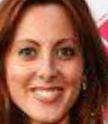
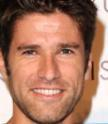
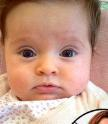
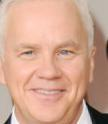

In [10]:
HTML(sample_data.head()[['tag', 'face_thumb']].to_html(formatters={'face_thumb': image_formatter}, escape=False))

- Loading the val_probe_image_list_unlabeled file that represent the excluded members to be used for the validation.



- The file is found to have 1086 records and 3 columns described as follows: 

    - id contains the a generated member id.
    - facepaths column contains a path to a photo of the person.
    - nfaces represent the number of photos for that person that exists in the database. 

In [11]:
test = pd.read_excel('test/val_probe_image_list_unlabeled.xlsx')
print(test.shape)
test.head()

(1086, 3)


,id,nfaces,facepaths
0,0,11,FIDs/F0007/MID2/P00074_face0.jpg
1,0,11,FIDs/F0007/MID2/P11274_face5.jpg
2,0,11,FIDs/F0007/MID2/P00073_face4.jpg
3,0,11,FIDs/F0007/MID2/P11275_face0.jpg
4,0,11,FIDs/F0007/MID2/P00075_face1.jpg


- Making a FID column that contains the family id of each member to be used against the predicted results.

- For the facepaths column the paths will be updated to be the correct paths for our machine.

In [12]:
test['FID'] = test.facepaths.str.extract(r'([F][0-9]{4})', expand = True)
test = test.replace(to_replace = r'^FIDs', value = 'test/FIDs', regex = True)
test.head()

,id,nfaces,facepaths,FID
0,0,11,test/FIDs/F0007/MID2/P00074_face0.jpg,F0007
1,0,11,test/FIDs/F0007/MID2/P11274_face5.jpg,F0007
2,0,11,test/FIDs/F0007/MID2/P00073_face4.jpg,F0007
3,0,11,test/FIDs/F0007/MID2/P11275_face0.jpg,F0007
4,0,11,test/FIDs/F0007/MID2/P00075_face1.jpg,F0007


- Counting the total number of images that existing in the codalab version of the database and keep all of the paths in an array called ppl.

- Flatten the ppl array to be easier for iterating process.

- Iterating on the facepaths column and comparing it's values with the values in the test_photos array (the flattened version of ppl) to make sure that all of the photos used in testing exists in this version of the database.

In [13]:
#keeps all photos path in a dictionary
allPhotos = defaultdict(list)
for family in glob.glob("test/FIDs/*"):
        for mem in glob.glob(family + '/*'):
            for photo in glob.glob(mem + '/*'):
                allPhotos[mem].append(photo)

#list of all members with valid photo
ppl = list(allPhotos.values())
print("number of the members with valid photos",len(ppl))
print("sample of the ppl content: ", ppl[:3])

def flatten(listOfLists):
    "Flatten one level of nesting"
    return chain.from_iterable(listOfLists)

test_photos = list(flatten(ppl))

print(len(test))
test = test[test.facepaths.isin(test_photos)]
print(len(test))

number of the members with valid photos 966
sample of the ppl content:  [['test/FIDs/F0644/MID1/P06777_face11.jpg', 'test/FIDs/F0644/MID1/P06787_face1.jpg', 'test/FIDs/F0644/MID1/P06779_face7.jpg', 'test/FIDs/F0644/MID1/P06775_face2.jpg', 'test/FIDs/F0644/MID1/P06783_face2.jpg', 'test/FIDs/F0644/MID1/P06782_face5.jpg', 'test/FIDs/F0644/MID1/P06778_face3.jpg', 'test/FIDs/F0644/MID1/P06785_face2.jpg', 'test/FIDs/F0644/MID1/P06781_face1.jpg', 'test/FIDs/F0644/MID1/P06792_face3.jpg'], ['test/FIDs/F0644/MID3/P06783_face4.jpg', 'test/FIDs/F0644/MID3/P06778_face5.jpg', 'test/FIDs/F0644/MID3/P06791_face1.jpg', 'test/FIDs/F0644/MID3/P06779_face6.jpg', 'test/FIDs/F0644/MID3/P06781_face0.jpg', 'test/FIDs/F0644/MID3/P06785_face3.jpg'], ['test/FIDs/F0644/MID5/P06785_face0.jpg', 'test/FIDs/F0644/MID5/P06775_face1.jpg', 'test/FIDs/F0644/MID5/P06778_face6.jpg', 'test/FIDs/F0644/MID5/P06779_face8.jpg', 'test/FIDs/F0644/MID5/P06783_face3.jpg']]
1086
1086


- According to the output from the pervious cell it's found that all the files in the dataframe refers to an existing images for this version of the database.

- Now let's check the classes/FID for both testing and traning.

In [14]:
print("Number of classes in training equal", len(df.FID.unique()))
print("Number of classes in testing equal", len(test.FID.unique()))

not_exist_fam = []

for val in list(df.FID.unique()):
    if not val in list(test.FID.unique()):
        not_exist_fam.append(val)
        
print("The families that doen't exists in the testing", not_exist_fam[:])

Number of classes in training equal 192
Number of classes in testing equal 185
The families that doen't exists in the testing ['F0351', 'F0409', 'F0450', 'F0520', 'F0575', 'F0620', 'F0758']


__Important:__

- In order to prevent all of evaluation problem due to this we will drop all rows with a member from one of those families from the training.

- It's good to mention that all those families in training but not in test have less than 5 members that's why their doesn't exist in the testing dataframe.

- After this step the df will have 3887 records instead of 4030 records!!

In [15]:
df = df[~df['FID'].isin(not_exist_fam)]
print(df.shape)

(3887, 4)


- Now we will search for the excluded member from the family visualized above to visualize it.

In [16]:
sample_test = test[test['FID'] == 'F0022'].groupby('id').first()
sample_test['face_thumb'] = sample_test.facepaths.map(lambda f: get_thumbnail(f))
print(sample_test.shape)

(1, 4)


,FID,face_thumb
id,,
1,F0022,

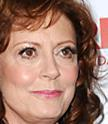

In [17]:
HTML(sample_test.head()[['FID', 'face_thumb']].to_html(formatters={'face_thumb': image_formatter}, escape=False))

## Data Preperation

- Working on the training data spilt it to 2 arrays as following:
    - __X__ that contains the training image to feed as input.
    - __y__ that contains the family id as the expected output.

In [18]:
train_image = []
for i in list(df['facepaths']):
    img = image.load_img(i,target_size = (224,224,3))
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)
print(X.shape)

(3887, 224, 224, 3)


In [19]:
df['FID'] = pd.Categorical(df['FID'])
y = np.array(pd.get_dummies(df['FID']))
print(y.shape)

(3887, 185)


- Spilt the training data arrays (X,y) to training and validation for better model training accuracy.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(type(X_train), type(X_test), type(y_train), type(y_test))

(3109, 224, 224, 3) (3109, 185) (778, 224, 224, 3) (778, 185)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


- Working on the testing/validation data spilt it to 2 arrays as following:
    - __X_pred__ that contains the validation images to feed as input.
    - __t_y_test__ that contains the family id as the expected output from prediction.

In [21]:
test_image = []
for i in list(test['facepaths']):
    img = image.load_img(i,target_size = (224,224,3))
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
X_pred = np.array(test_image)
print(X_pred.shape)

(1086, 224, 224, 3)


In [22]:
test['FID'] = pd.Categorical(test['FID'])
t_y_test = pd.get_dummies(test['FID'])
print(t_y_test.shape)
t_y_test.head()

(1086, 185)


,F0007,F0022,F0040,F0044,F0053,F0063,F0065,F0071,F0074,F0087,...,F0931,F0939,F0943,F0970,F0982,F0986,F0990,F0996,F0999,F1004
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
t_y_test = np.array(t_y_test)

## Benchmark Solution

- For a benchmark solution the random guessing will be used and this will be done as follows:

    - Keeps the families codes (classes) in an array called __families__.
    - Using random library we will make an array of random generated family codes called __fam__.
    - Constructing a dataframe with a FID column with the __fam__. this is done to make it easier to convert to the 1 hot encoder format.

In [24]:
families = list(df.FID.unique())
print(len(families))

185


In [25]:
import random 

random.seed()

fam = []
rand_guess = pd.DataFrame(columns = ['FID'])
for i in range(0,X_pred.shape[0]):
    # as we have 185 different class
    fam.append(families[random.randint(0, 184)])

rand_guess["FID"] = fam  
print(rand_guess.shape)
rand_guess.head()

(1086, 1)


,FID
0,F0278
1,F0427
2,F0360
3,F0390
4,F0474


In [26]:
rand_guess['FID'] = pd.Categorical(rand_guess['FID'])
rand_guess_arr = np.array(pd.get_dummies(rand_guess['FID']))

- Calculating the accuracy and visualizing the confusion matrix of the results.

In [27]:
from sklearn.metrics import accuracy_score

accuracy_score(t_y_test, rand_guess_arr)

0.0064456721915285451

-------------------------------------------------------------------------------------
Random Guess Confusion Matrix [[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
-------------------------------------------------------------------------------------


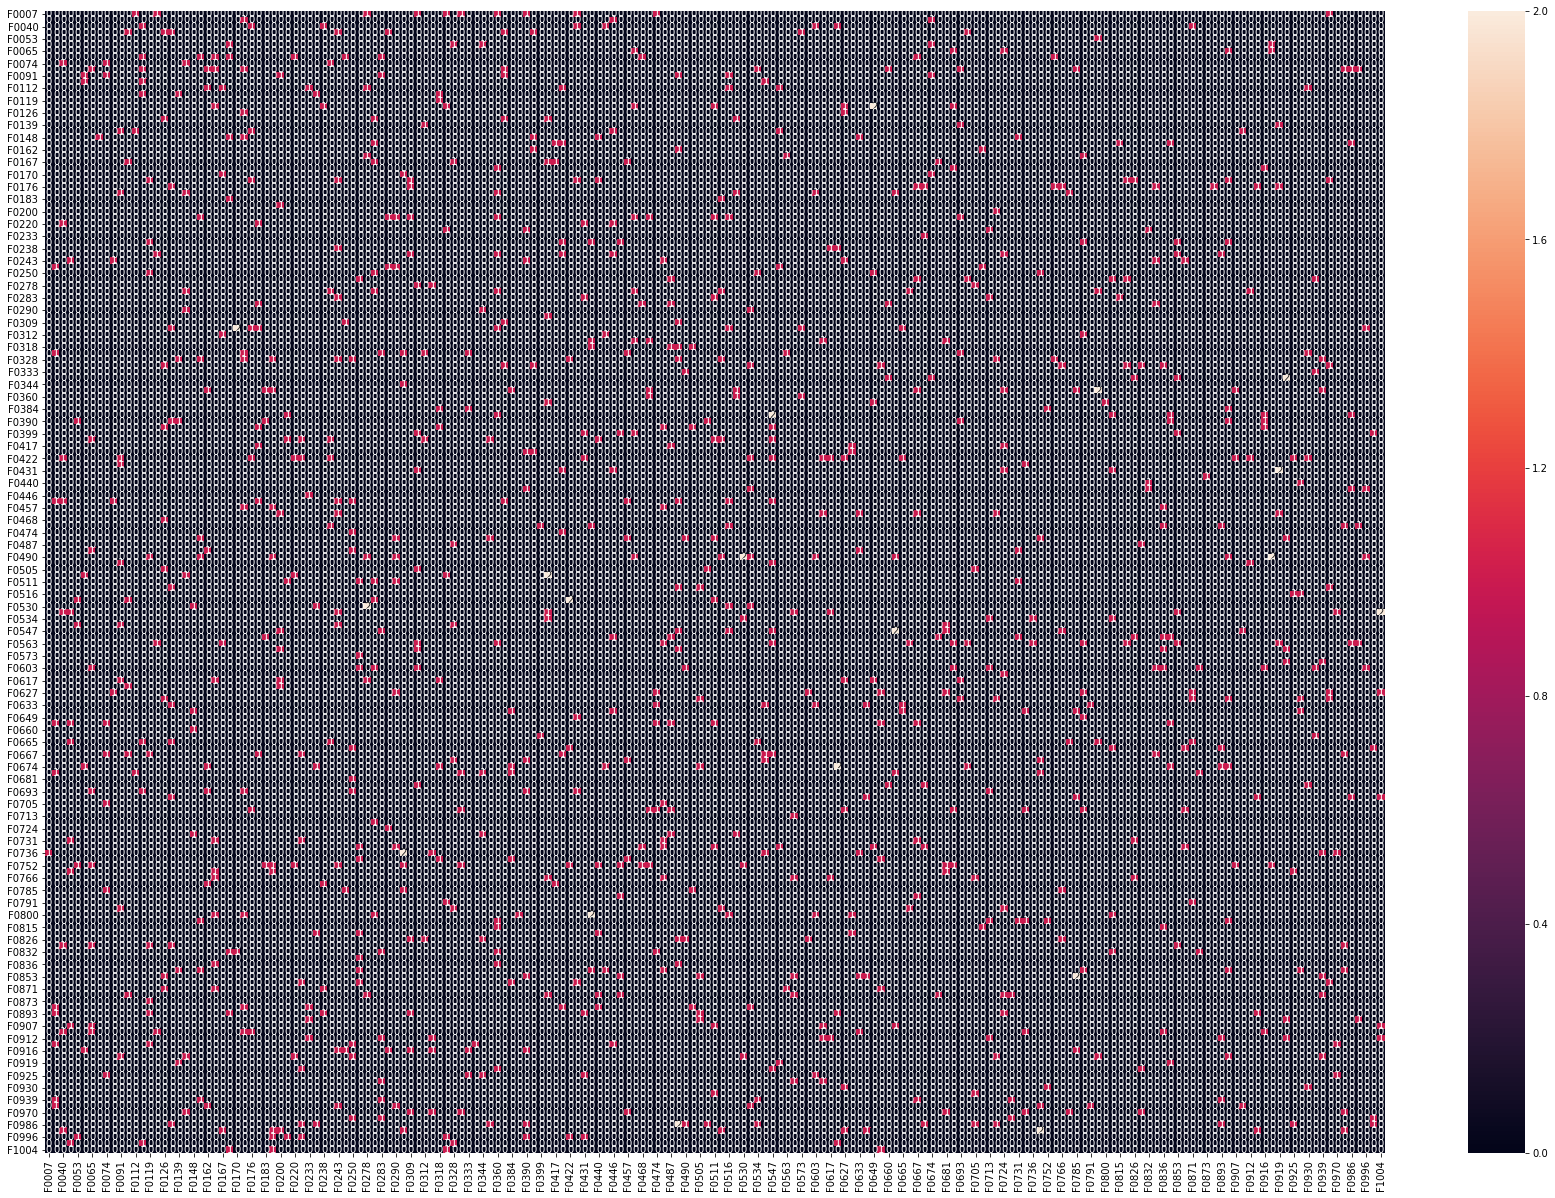

In [28]:
# Confution Matrix for better visualization
from sklearn.metrics import confusion_matrix

print('-------------------------------------------------------------------------------------')
matrix = confusion_matrix(t_y_test.argmax(axis = 1), rand_guess_arr.argmax(axis = 1))
print("Random Guess Confusion Matrix", matrix, end = '\n')
df_cm = pd.DataFrame(matrix, index = [i for i in families],
                     columns = [i for i in families])
plt.figure(figsize = (30,21))
sn.heatmap(df_cm, annot = True)
print('-------------------------------------------------------------------------------------')

## Proposed Model

- For the main model, a simple CNN is trained on the training data and then the model used for predicting the excluded members.

In [29]:
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint  
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [30]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = 2, activation = "relu", input_shape = (224,224,3)))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = 2, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = 2, padding='same', activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = 2, padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(185, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 55, 55, 64)        8256      
__________

- Compile the CNN and train it.

In [31]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [32]:
checkpointer = ModelCheckpoint(filepath = 'weights.best.from_scratch.hdf5', 
                               verbose = 1, save_best_only = True)

model.fit(X_train, y_train, epochs = 100,
          validation_data = (X_test, y_test),
          batch_size = 100, callbacks = [checkpointer], verbose = 1)

Train on 3109 samples, validate on 778 samples
Epoch 1/100
3109/3109 [==============================] - 14s 4ms/step - loss: 5.2400 - acc: 0.0109 - val_loss: 5.2105 - val_acc: 0.0180
Epoch 2/100
3109/3109 [==============================] - 12s 4ms/step - loss: 5.1569 - acc: 0.0158 - val_loss: 5.2001 - val_acc: 0.0180
Epoch 3/100
3109/3109 [==============================] - 12s 4ms/step - loss: 5.1464 - acc: 0.0225 - val_loss: 5.1923 - val_acc: 0.0180
Epoch 4/100
3109/3109 [==============================] - 12s 4ms/step - loss: 5.1181 - acc: 0.0222 - val_loss: 5.1880 - val_acc: 0.0180
Epoch 5/100
3109/3109 [==============================] - 12s 4ms/step - loss: 5.0961 - acc: 0.0254 - val_loss: 5.1827 - val_acc: 0.0180
Epoch 6/100
3109/3109 [==============================] - 12s 4ms/step - loss: 5.0874 - acc: 0.0241 - val_loss: 5.1711 - val_acc: 0.0180
Epoch 7/100
3109/3109 [==============================] - 12s 4ms/step - loss: 5.0741 - acc: 0.0222 - val_loss: 5.1641 - val_acc: 0.0180
E

Epoch 29/100
3109/3109 [==============================] - 12s 4ms/step - loss: 4.6387 - acc: 0.0576 - val_loss: 4.8445 - val_acc: 0.0578
Epoch 30/100
3109/3109 [==============================] - 12s 4ms/step - loss: 4.6421 - acc: 0.0630 - val_loss: 4.8048 - val_acc: 0.0733
Epoch 31/100
3109/3109 [==============================] - 12s 4ms/step - loss: 4.6131 - acc: 0.0647 - val_loss: 4.8085 - val_acc: 0.0617
Epoch 32/100
3109/3109 [==============================] - 12s 4ms/step - loss: 4.5704 - acc: 0.0634 - val_loss: 4.7463 - val_acc: 0.0720
Epoch 33/100
3109/3109 [==============================] - 12s 4ms/step - loss: 4.5691 - acc: 0.0624 - val_loss: 4.8283 - val_acc: 0.0488
Epoch 34/100
3109/3109 [==============================] - 12s 4ms/step - loss: 4.5342 - acc: 0.0656 - val_loss: 4.8432 - val_acc: 0.0411
Epoch 35/100
3109/3109 [==============================] - 12s 4ms/step - loss: 4.5350 - acc: 0.0698 - val_loss: 4.7277 - val_acc: 0.0668
Epoch 36/100
3109/3109 [=================

3109/3109 [==============================] - 12s 4ms/step - loss: 4.0583 - acc: 0.1039 - val_loss: 4.4836 - val_acc: 0.1003
Epoch 59/100
3109/3109 [==============================] - 12s 4ms/step - loss: 4.0221 - acc: 0.1113 - val_loss: 4.5542 - val_acc: 0.0938
Epoch 60/100
3109/3109 [==============================] - 12s 4ms/step - loss: 4.0507 - acc: 0.1139 - val_loss: 4.5432 - val_acc: 0.0977
Epoch 61/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.9954 - acc: 0.1174 - val_loss: 4.6131 - val_acc: 0.0900
Epoch 62/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.9763 - acc: 0.1142 - val_loss: 4.4705 - val_acc: 0.1105
Epoch 63/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.9441 - acc: 0.1254 - val_loss: 4.4586 - val_acc: 0.1080
Epoch 64/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.9681 - acc: 0.1081 - val_loss: 4.5609 - val_acc: 0.0990
Epoch 65/100
3109/3109 [==============================

Epoch 88/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.5695 - acc: 0.1682 - val_loss: 4.5838 - val_acc: 0.1183
Epoch 89/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.5588 - acc: 0.1673 - val_loss: 4.4309 - val_acc: 0.1414
Epoch 90/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.5332 - acc: 0.1621 - val_loss: 4.4287 - val_acc: 0.1234
Epoch 91/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.5203 - acc: 0.1737 - val_loss: 4.4032 - val_acc: 0.1247
Epoch 92/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.5698 - acc: 0.1647 - val_loss: 4.4440 - val_acc: 0.1208
Epoch 93/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.4586 - acc: 0.1689 - val_loss: 4.5335 - val_acc: 0.1093
Epoch 94/100
3109/3109 [==============================] - 12s 4ms/step - loss: 3.4868 - acc: 0.1695 - val_loss: 4.4170 - val_acc: 0.1195
Epoch 95/100
3109/3109 [=================

- Testing the model be using it to predict the excluded members class/family.

In [33]:
y_pred = model.predict(X_pred)

- Calculating the accuracy and visualizing the confusion matrix of the results.

In [34]:
y_pred = (y_pred > 0.5) 
accuracy_score(t_y_test, y_pred)

0.0055248618784530384

-------------------------------------------------------------------------------------
Confusion Matrix [[10  0  0 ...,  0  0  0]
 [ 3  0  0 ...,  0  0  0]
 [ 8  0  0 ...,  0  0  0]
 ..., 
 [ 8  0  0 ...,  0  0  0]
 [ 4  0  0 ...,  0  0  0]
 [ 4  0  0 ...,  0  0  0]]
-------------------------------------------------------------------------------------
Classification Report              precision    recall  f1-score   support

      F0007       0.00      0.00      0.00        11
      F0022       0.00      0.00      0.00         3
      F0040       0.00      0.00      0.00         8
      F0044       0.00      0.00      0.00         9
      F0053       0.00      0.00      0.00         1
      F0063       0.00      0.00      0.00         5
      F0065       0.00      0.00      0.00         5
      F0071       0.00      0.00      0.00        10
      F0074       0.00      0.00      0.00         4
      F0087       0.00      0.00      0.00        13
      F0091       0.00      0.00      0.0

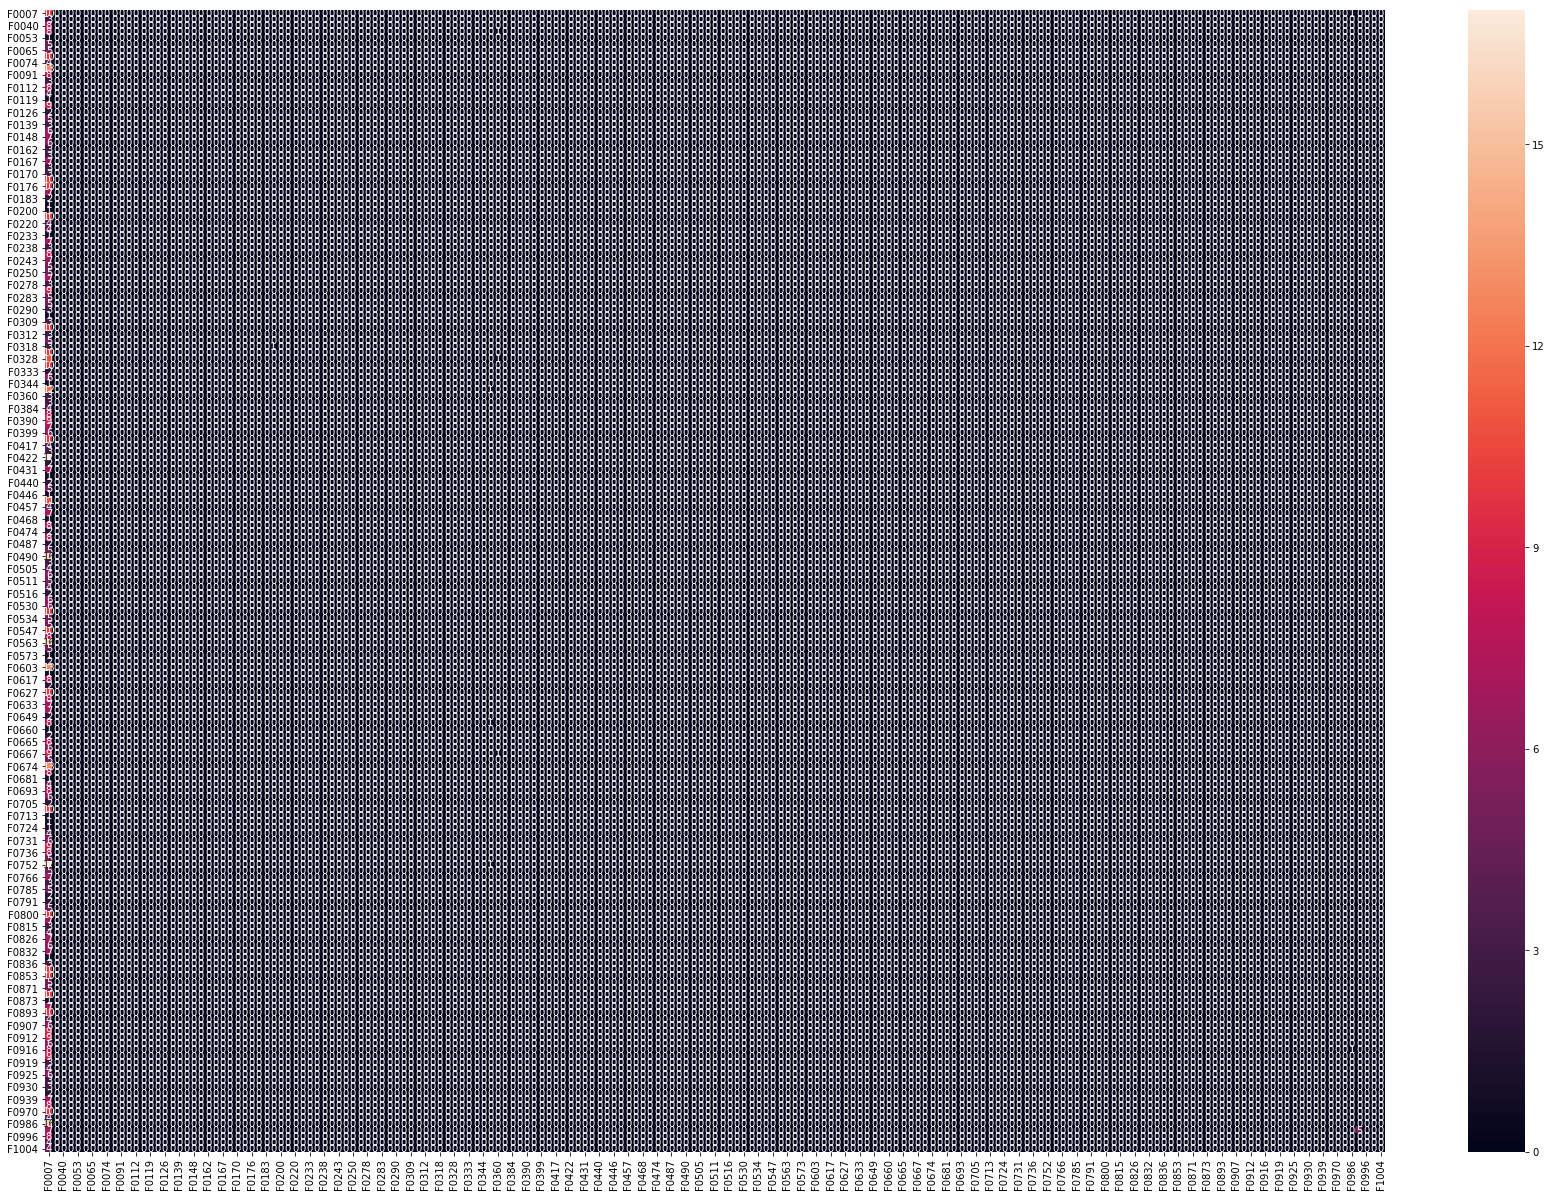

In [36]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report

print('-------------------------------------------------------------------------------------')
matrix = confusion_matrix(t_y_test.argmax(axis = 1), y_pred.argmax(axis = 1))
print("Confusion Matrix", matrix, end = '\n')
df_cm = pd.DataFrame(matrix, index = [i for i in families],
                     columns = [i for i in families])
plt.figure(figsize = (30,21))
sn.heatmap(df_cm, annot = True)

print('-------------------------------------------------------------------------------------')

report = classification_report(t_y_test, y_pred, target_names = families)
print("Classification Report", report, end = '\n')
print('-------------------------------------------------------------------------------------')